# 📘 Tutorial 3: Model Submission Template

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hypertrial/Stacking-Sats/blob/main/tutorials/3.%20Submission_Template.ipynb)

This tutorial walks you through the **standard submission workflow** for the challenge. It simulates the exact structure used to evaluate your model using three key code blocks:

1. **Prelude Cell** — A shared setup environment used by all submissions. This includes imports, utility functions, and any shared constants (boilerplate).
2. **Program Cell** — The core of your submission. Here, you define your model logic that maps observable features to daily weight allocations.
3. **Runner Cell** — A test harness that evaluates your model on historical cycles for validity and performance. This is how your submission will be validated and ranked (boilerplate).

---

By the end of this notebook, you should be ready to:
- Modify the **Program Cell** to implement your own dynamic DCA strategy.
- Understand what imports, data, and global varables the **Prelude Cell** defines.
- Understand how the **Runner Cell** uses your model for backtesting.
- Submit a valid and testable entry for the challenge.

This notebook ensures that all submissions conform to a consistent structure for **fair evaluation** and **reproducibility**.

## Prelude.py

In [3]:
# ---------------------------
# Prelude: Imports and Data Loading Setup
# ---------------------------
import pandas as pd
from datetime import datetime
import logging
import matplotlib.pyplot as plt
import numpy as np

try:
    from coinmetrics.api_client import CoinMetricsClient
except ImportError:
    raise ImportError("coinmetrics.api_client module is required. Install it via pip if necessary.")

# Configure logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Initialize Coin Metrics API client
client = CoinMetricsClient()

# Define asset, metric, and time range
asset = 'btc'
metric = 'PriceUSD'
start_time = '2010-01-01'
end_time = datetime.today().strftime('%Y-%m-%d')  # today's date
frequency = '1d'

# Fetch the metric data for the specified asset and time range
logging.info("Fetching BTC ReferenceRate...")
btc_df = client.get_asset_metrics(
    assets=asset,
    metrics=[metric],
    frequency=frequency,
    start_time=start_time,
    end_time=end_time
).to_dataframe()

# Rename and format data
btc_df = btc_df.rename(columns={metric: 'Close'})
btc_df['time'] = pd.to_datetime(btc_df['time']).dt.normalize()
btc_df['time'] = btc_df['time'].dt.tz_localize(None)
btc_df.set_index('time', inplace=True)
btc_df = btc_df[['Close']]
btc_df = btc_df.rename(columns={"Close": "btc_close"})

print(btc_df.info())
display(btc_df)

BACKTEST_START = '2013-01-01'
BACKTEST_END = '2024-12-31'

2025-03-30 14:55:04 INFO     Fetching BTC ReferenceRate...
2025-03-30 14:55:06 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2025-03-30 14:55:13 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2025-03-30 14:55:21 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2025-03-30 14:55:28 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5369 entries, 2010-07-18 to 2025-03-29
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   btc_close  5369 non-null   Float64
dtypes: Float64(1)
memory usage: 89.1 KB
None


,btc_close
time,
2010-07-18,0.08584
2010-07-19,0.0808
2010-07-20,0.074736
2010-07-21,0.079193
2010-07-22,0.05847
...,...
2025-03-25,87422.842608
2025-03-26,86836.676096
2025-03-27,87211.324017


## Program.py

In [5]:
# -----------------------------------------------------------------------------
# GLOBAL CONFIGURATION
# -----------------------------------------------------------------------------
# Define the start and end dates for the backtest period
BACKTEST_START = '2013-01-01'
BACKTEST_END = '2024-12-31'

# Scaling factor for the boost based on the z-score
ALPHA = 1.25  # For each unit z, the weight is increased by 20%

# The window (in days) over which redistribution is applied
REBALANCE_WINDOW = 365 * 2  # Two years' worth of days

# Minimum allowable weight for any day to ensure no weight falls below this value
MIN_WEIGHT = 1e-4         

# -----------------------------------------------------------------------------
# 1) Feature Construction Function: construct_features
# -----------------------------------------------------------------------------
def construct_features(df):
    """
    Constructs additional features needed for the strategy.
    
    This function calculates:
      - The 200-day moving average ('ma200') of btc_close.
      - The 200-day rolling standard deviation ('std200') of btc_close.
    
    Parameters:
        df (pd.DataFrame): DataFrame with at least a 'btc_close' column.
    
    Returns:
        pd.DataFrame: A new DataFrame including the original data and the computed features.
    """
    # Create a copy of the DataFrame to avoid modifying the original data
    df = df.copy()
    
    # Calculate the 200-day moving average of the 'btc_close' price.
    df['ma200'] = df['btc_close'].rolling(window=200, min_periods=1).mean()
    
    # Calculate the 200-day rolling standard deviation of the 'btc_close' price.
    df['std200'] = df['btc_close'].rolling(window=200, min_periods=1).std()
    
    return df

# -----------------------------------------------------------------------------
# 2) Dynamic Budget Allocation Function:
#    Implements a constrained early bias rebalancing strategy using a z-score.
# -----------------------------------------------------------------------------
def dynamic_budget_allocation(df):
    """
    Allocates dynamic weights based on a constrained early bias rebalancing strategy.
    
    For each cycle (defined as a 4-year period starting from the backtest start year), 
    the function adjusts the weights for each day. If the current price is below its 
    200-day moving average, it calculates the z-score:
    
        z = (ma200 - price) / std200
        
    and then computes a boost multiplier:
    
        boost_multiplier = 1 + ALPHA * z
    
    The boosted weight is then derived by multiplying the current weight with this 
    multiplier. The excess weight (boosted_weight - current_weight) is redistributed 
    evenly over the future days in the rebalancing window, ensuring that no day's 
    weight falls below MIN_WEIGHT.
    
    Parameters:
        df (pd.DataFrame): DataFrame with required features (e.g., 'btc_close', 'ma200', 'std200').
    
    Returns:
        pd.Series: A Series containing the dynamically allocated weights for each day.
    """
    # Initialize an empty Series to store the final weights with the same index as the input DataFrame
    weights = pd.Series(index=df.index, dtype=float)
    
    # Determine the starting year from the backtest start date for cycle calculation
    start_year = pd.to_datetime(BACKTEST_START).year
    
    # Create cycle labels for grouping: each cycle spans 4 years.
    cycle_labels = df.index.to_series().apply(lambda dt: (dt.year - start_year) // 4)
    
    # Iterate through each cycle group based on the calculated labels
    for cycle, group in df.groupby(cycle_labels):
        N = len(group)  # Total number of days in the current cycle
        base_weight = 1.0 / N  # Initial equal weight for each day in the cycle
        temp_weights = np.full(N, base_weight)  # Create an array of weights for the cycle
        
        # This flag controls whether the boosting strategy is active.
        # Once the feasibility check fails for a day, further boosting attempts will be stopped.
        strategy_active = True

        # Loop over each day in the current cycle to evaluate and adjust weights
        for i in range(N):
            if not strategy_active:
                break

            price = group['btc_close'].iloc[i]
            ma200 = group['ma200'].iloc[i]
            std200 = group['std200'].iloc[i]
            
            # Only attempt to boost if the price is below MA200 and we have a valid std deviation
            if price < ma200 and std200 > 0:
                # Compute the z-score for how much cheaper the price is compared to MA200
                z = (ma200 - price) / std200
                # Calculate the boost multiplier based on the z-score
                boost_multiplier = 1 + ALPHA * z
                current_weight = temp_weights[i]
                boosted_weight = current_weight * boost_multiplier
                excess = boosted_weight - current_weight

                # Determine the start index for redistribution.
                # Redistribution applies to future days, starting from day i+1 up to the REBALANCE_WINDOW limit.
                start_redistribution = max(N - REBALANCE_WINDOW, i + 1)
                if start_redistribution >= N:
                    continue

                redistribution_idx = np.arange(start_redistribution, N)
                reduction = excess / len(redistribution_idx)
                projected = temp_weights[redistribution_idx] - reduction

                if np.all(projected >= MIN_WEIGHT):
                    temp_weights[i] = boosted_weight
                    temp_weights[redistribution_idx] -= reduction
                else:
                    strategy_active = False

        weights.loc[group.index] = temp_weights

    return weights

# -----------------------------------------------------------------------------
# 3) Dynamic Rule Causal Function: dynamic_rule_causal
# -----------------------------------------------------------------------------
def dynamic_rule_causal(df):
    """
    Orchestrates the dynamic strategy by constructing features, limiting the DataFrame 
    to the backtest period, and then applying the dynamic budget allocation strategy.
    
    Parameters:
        df (pd.DataFrame): Original DataFrame containing the 'btc_close' column.
    
    Returns:
        pd.Series: A Series of dynamically allocated weights corresponding to the backtest period.
    """
    df_features = construct_features(df)
    df_features = df_features.loc[BACKTEST_START:BACKTEST_END]
    weights = dynamic_budget_allocation(df_features)
    return weights

## Runner.py

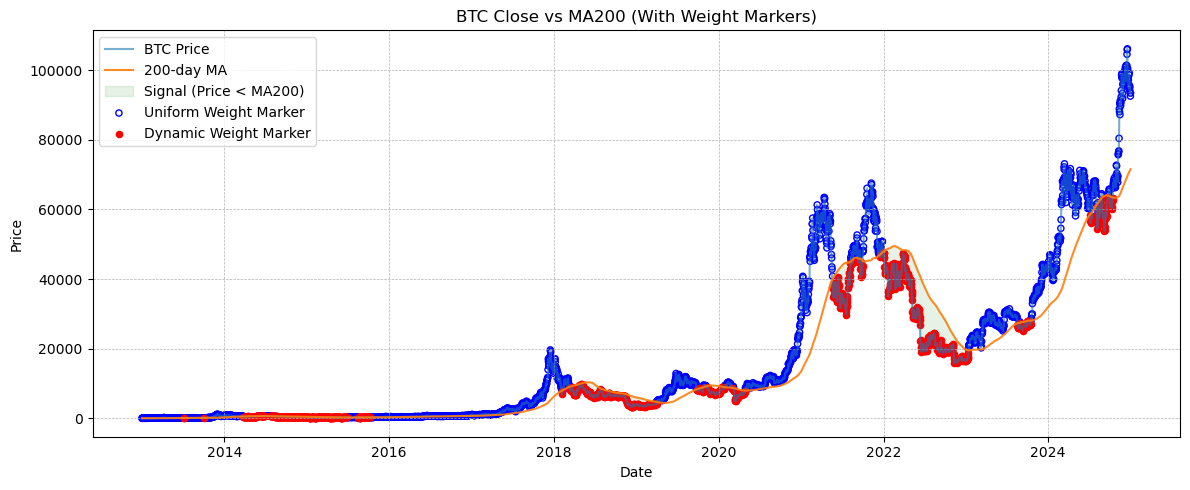

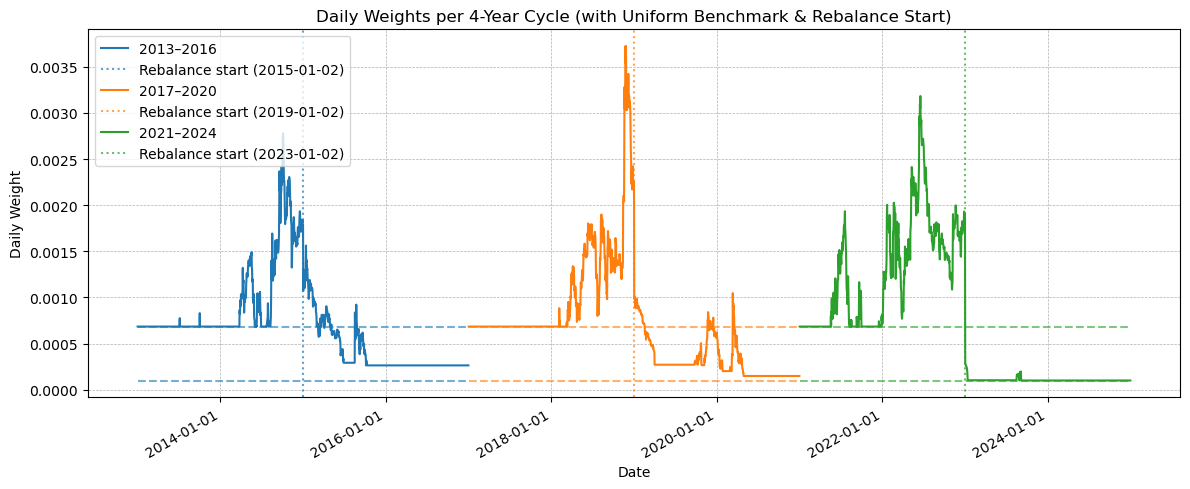

Weight sums by cycle (should be close to 1.0):
Cycle 2013–2016: 1.0000
Cycle 2017–2020: 1.0000
Cycle 2021–2024: 1.0000


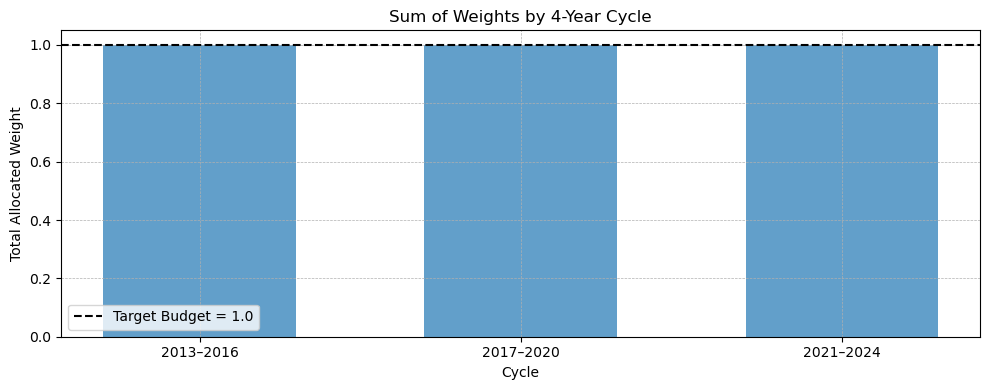

In [7]:
# -----------------------------------------------------------------------------
# GLOBAL BACKTEST RANGE (already defined globally)
# -----------------------------------------------------------------------------
BACKTEST_START = '2013-01-01'
BACKTEST_END = '2024-12-31'


# -----------------------------------------------------------------------------
# 1) Plot MA200 Signal vs Price
# -----------------------------------------------------------------------------

def plot_price_vs_ma200(df_features, weights=None):
    """
    Plot BTC price vs MA200 and overlay signal regions and optional weight markers.

    If weights are provided:
        - Unfilled circle → uniform allocation (price >= MA200)
        - Filled circle → dynamic allocation (price < MA200)
    """
    import matplotlib.pyplot as plt

    df_plot = df_features.loc[BACKTEST_START:BACKTEST_END].copy()

    plt.figure(figsize=(12, 5))
    plt.plot(df_plot.index, df_plot['btc_close'], label='BTC Price', alpha=0.6)
    plt.plot(df_plot.index, df_plot['ma200'], label='200-day MA', alpha=0.9)

    # Highlight areas where the signal is active
    plt.fill_between(
        df_plot.index,
        df_plot['btc_close'],
        df_plot['ma200'],
        where=(df_plot['btc_close'] < df_plot['ma200']),
        color='green',
        alpha=0.1,
        label='Signal (Price < MA200)'
    )

    if weights is not None:
        # Find where the signal triggers
        signal_mask = df_plot['btc_close'] < df_plot['ma200']

        # Plot uniform (unfilled) weights
        uniform_dates = df_plot.index[~signal_mask]
        plt.scatter(uniform_dates, df_plot.loc[~signal_mask, 'btc_close'],
                    marker='o', edgecolors='blue', facecolors='none', label='Uniform Weight Marker', s=20)

        # Plot dynamic (filled) weights
        dynamic_dates = df_plot.index[signal_mask]
        plt.scatter(dynamic_dates, df_plot.loc[signal_mask, 'btc_close'],
                    marker='o', color='red', label='Dynamic Weight Marker', s=20)

    plt.title("BTC Close vs MA200 (With Weight Markers)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# 2) Plot Final Daily Weights (Restricted to Backtest Window)
# -----------------------------------------------------------------------------
def plot_final_weights(weights):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.cm as cm
    import numpy as np

    weights_bt = weights.loc[BACKTEST_START:BACKTEST_END].copy()
    start_year = pd.to_datetime(BACKTEST_START).year
    cycle_labels = weights_bt.index.to_series().apply(lambda dt: (dt.year - start_year) // 4)

    cmap = plt.colormaps.get_cmap('tab10')
    fig, ax = plt.subplots(figsize=(12, 5))

    for cycle, group in weights_bt.groupby(cycle_labels):
        label = f"{start_year + 4*cycle}–{start_year + 4*cycle + 3}"
        color = cmap(cycle % 10)

        # Plot actual daily weights
        ax.plot(group.index, group.values, label=label, color=color)

        # Uniform benchmark
        N = len(group)
        uniform = 1.0 / N
        ax.hlines(uniform, group.index.min(), group.index.max(), color=color, linestyle='--', alpha=0.6)

        # MIN_WEIGHT benchmark
        ax.hlines(MIN_WEIGHT, group.index.min(), group.index.max(), color=color, linestyle='--', alpha=0.6)
        
        # Plot vertical line indicating the start of the redistribution window
        rebalance_start_date = group.index[-REBALANCE_WINDOW]
        ax.axvline(x=rebalance_start_date, color=color, linestyle=':', alpha=0.7, 
                   label=f'Rebalance start ({rebalance_start_date.strftime("%Y-%m-%d")})')

    ax.set_title("Daily Weights per 4-Year Cycle (with Uniform Benchmark & Rebalance Start)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Daily Weight")
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------------------------
# 3) Plot Sum of Weights per 4-Year Cycle (Restricted to Backtest Window)
# -----------------------------------------------------------------------------
def plot_weight_sums_by_cycle(weights):
    """
    Plots the total allocated weight by 4-year cycles and prints the sum of weights
    for each cycle to validate that they sum to 1.
    
    Parameters:
        weights (pd.Series): Series of weights with datetime index.
    """
    # Filter the weights to the backtest period
    weights_bt = weights.loc[BACKTEST_START:BACKTEST_END].copy()
    
    # Determine the starting year for cycles based on the backtest start date
    start_year = pd.to_datetime(BACKTEST_START).year
    
    # Create cycle labels where each cycle spans 4 years
    cycle_labels = weights_bt.index.to_series().apply(lambda dt: (dt.year - start_year) // 4)
    
    # Calculate the sum of weights for each cycle
    weight_sums = weights_bt.groupby(cycle_labels).sum()
    
    # Print the cycle weight sums for validation
    print("Weight sums by cycle (should be close to 1.0):")
    for cycle, total in weight_sums.items():
        print(f"Cycle {(start_year + 4*cycle)}–{(start_year + 4*cycle + 3)}: {total:.4f}")
    
    # Optional: create human-readable labels like "2012–2015"
    label_map = {i: f"{start_year + 4*i}–{start_year + 4*i + 3}" for i in weight_sums.index}

    # Plot the weight sums by cycle
    plt.figure(figsize=(10, 4))
    plt.bar([label_map[i] for i in weight_sums.index], weight_sums.values, width=0.6, alpha=0.7)
    plt.axhline(1.0, linestyle='--', color='black', label='Target Budget = 1.0')
    plt.title("Sum of Weights by 4-Year Cycle")
    plt.xlabel("Cycle")
    plt.ylabel("Total Allocated Weight")
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Assume btc_df is loaded
    df_features = construct_features(btc_df).loc[BACKTEST_START:BACKTEST_END]
    weights = dynamic_rule_causal(btc_df)

    plot_price_vs_ma200(df_features, weights=weights)
    #plot_price_vs_ma200(df_features)
    plot_final_weights(weights)
    plot_weight_sums_by_cycle(weights)


Aggregated Metrics for Threshold-Based DCA:
Dynamic SPD:
  min: 3483.32
  max: 596331.15
  mean: 208261.15
  median: 24968.98
Dynamic SPD Percentile:
  min: 6.83
  max: 47.02
  mean: 23.76
  median: 17.44

Excess SPD Percentile Difference (Dynamic - Uniform) per Cycle:
  2013–2016: 0.14%
  2017–2020: 1.94%
  2021–2024: 11.66%


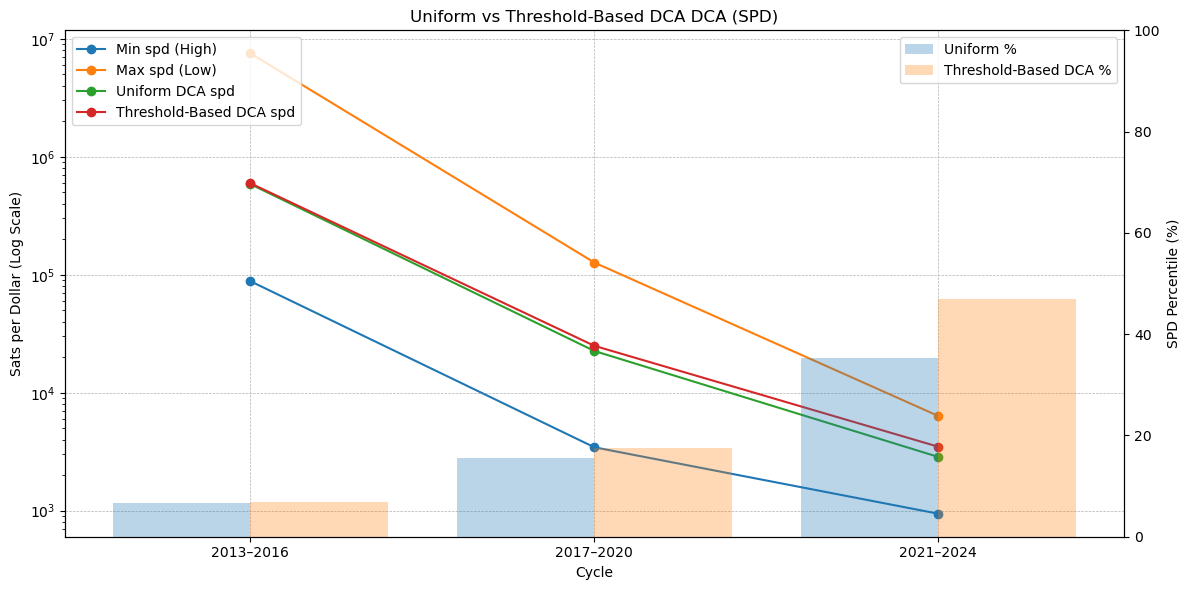

In [16]:
# Revised functions
def compute_cycle_spd(df, weight_fn):
    """
    Compute SPD (sats-per-dollar) metrics over 4-year investment cycles
    from BACKTEST_START to BACKTEST_END.
    """
    df_backtest = df.loc[BACKTEST_START:BACKTEST_END]
    cycle_length = pd.DateOffset(years=4)
    current = df_backtest.index.min()
    rows = []

    # Compute weights using the provided weight function
    full_weights = weight_fn(df).fillna(0).clip(lower=0)

    while current <= df_backtest.index.max():
        cycle_end = current + cycle_length - pd.Timedelta(days=1)
        cycle = df_backtest.loc[current : min(cycle_end, df_backtest.index.max())]
        if cycle.empty:
            break

        cycle_label = f"{current.year}–{min(cycle_end.year, df_backtest.index.max().year)}"

        high, low = cycle['btc_close'].max(), cycle['btc_close'].min()
        min_spd = (1 / high) * 1e8
        max_spd = (1 / low) * 1e8
        uniform_spd = ((1 / cycle['btc_close']).sum() / len(cycle)) * 1e8

        w_slice = full_weights.loc[cycle.index]
        dynamic_spd = ((w_slice / cycle['btc_close']).sum()) * 1e8

        uniform_pct = (uniform_spd - min_spd) / (max_spd - min_spd) * 100
        dynamic_pct = (dynamic_spd - min_spd) / (max_spd - min_spd) * 100
        excess_pct = dynamic_pct - uniform_pct  # Excess SPD percentile difference

        rows.append({
            'cycle': cycle_label,
            'min_spd': min_spd,
            'max_spd': max_spd,
            'uniform_spd': uniform_spd,
            'dynamic_spd': dynamic_spd,
            'uniform_pct': uniform_pct,
            'dynamic_pct': dynamic_pct,
            'excess_pct': excess_pct
        })

        current += cycle_length

    return pd.DataFrame(rows).set_index('cycle')


def plot_spd_comparison(df_res, strategy_name):
    """
    Plot comparison of Uniform DCA vs Dynamic DCA SPD values and their percentiles.
    """
    x = np.arange(len(df_res.index))

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_yscale('log')

    ax1.plot(x, df_res['min_spd'], marker='o', label='Min spd (High)')
    ax1.plot(x, df_res['max_spd'], marker='o', label='Max spd (Low)')
    ax1.plot(x, df_res['uniform_spd'], marker='o', label='Uniform DCA spd')
    ax1.plot(x, df_res['dynamic_spd'], marker='o', label=f"{strategy_name} spd")

    ax1.set_title(f"Uniform vs {strategy_name} DCA (SPD)")
    ax1.set_ylabel('Sats per Dollar (Log Scale)')
    ax1.set_xlabel("Cycle")
    ax1.grid(True, linestyle='--', linewidth=0.5)
    ax1.legend(loc='upper left')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_res.index)

    ax2 = ax1.twinx()
    barw = 0.4
    ax2.bar(x - barw/2, df_res['uniform_pct'], width=barw, alpha=0.3, label='Uniform %')
    ax2.bar(x + barw/2, df_res['dynamic_pct'], width=barw, alpha=0.3, label=f"{strategy_name} %")
    ax2.set_ylabel('SPD Percentile (%)')
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


def backtest_dynamic_dca(df, strategy_name="Threshold-Based DCA"):
    """
    Run the backtest for the threshold-triggered DCA strategy over 4-year cycles,
    compute SPD metrics, and plot the results.
    """
    df_res = compute_cycle_spd(df, dynamic_rule_causal)

    dynamic_spd_metrics = {
        'min': df_res['dynamic_spd'].min(),
        'max': df_res['dynamic_spd'].max(),
        'mean': df_res['dynamic_spd'].mean(),
        'median': df_res['dynamic_spd'].median()
    }

    dynamic_pct_metrics = {
        'min': df_res['dynamic_pct'].min(),
        'max': df_res['dynamic_pct'].max(),
        'mean': df_res['dynamic_pct'].mean(),
        'median': df_res['dynamic_pct'].median()
    }

    print(f"\nAggregated Metrics for {strategy_name}:")
    print("Dynamic SPD:")
    for key, value in dynamic_spd_metrics.items():
        print(f"  {key}: {value:.2f}")
    print("Dynamic SPD Percentile:")
    for key, value in dynamic_pct_metrics.items():
        print(f"  {key}: {value:.2f}")
    
    # Print excess SPD percentile difference for each cycle
    print("\nExcess SPD Percentile Difference (Dynamic - Uniform) per Cycle:")
    for cycle, row in df_res.iterrows():
        print(f"  {cycle}: {row['excess_pct']:.2f}%")

    plot_spd_comparison(df_res, strategy_name)


if __name__ == '__main__':
    strategy_name = "Threshold-Based DCA"
    
    # Apply strategy to compute weights
    weights = dynamic_rule_causal(btc_df)
    
    # Run backtest and show SPD comparison plot
    backtest_dynamic_dca(btc_df, strategy_name=strategy_name)

In [9]:
# Save the weights to use in Tutoral 1
weights.to_csv('dynamic_weights.csv')